In [6]:
#Cell 0 — 스펙 고정(상수/리스트/정책)
# === SPEC: 공통 스펙/정책 (변경되면 반드시 기록) ==========================
TARGET   = "nins"
ID_COL   = "pv_id"
TIME_COL = "time"

# 모델에 직접 투입할 '원천' (합의본)
MODEL_FEATURE_SOURCES = [
    "ceiling",
    "real_feel_temp", "real_feel_temp_shade",
    "uv_idx",
    "wind_spd_b",
    "cloud_a",
    "humidity",
    "coord1", "coord2",
]

# 파생에만 쓰고 즉시 드롭할 원천 (source_only)
SOURCE_ONLY = [
    "cloud_b", "vis", "wind_spd_a",
    "temp_a", "dew_point",
    "precip_1h",
    TIME_COL,                 # 시간 파생 만든 뒤 드롭
]

# 메타(학습 입력엔 사용하지 않음)
META_COLS = [ID_COL, TARGET, "type", "energy"]

# 파생으로 추가될 컬럼(참고용 — 생성은 함수에서)
DERIVED_FEATURES = [
    # 시간
    "hour","month","dow","doy","hour_sin","hour_cos","doy_sin","doy_cos",
    # 구름/자외선
    "cloud_mean","cloud_a_norm","uv_cloud_adj","ceil_inv",
    # 가시/습윤
    "dew_spread","haze",
    # 강수
    "is_rain",
    # 바람
    "wind_spd_sum",
]

# 야간 필터 정책: 'cosz' | 'uv' | 'hour' | 'none'
NIGHT_POLICY   = "uv"     # 기본: uv_idx > 0
RAIN_THRESHOLD = 0.1      # is_rain 임계치 (0 또는 0.1 권장)
EPS            = 1e-6
RANDOM_STATE   = 42


In [7]:
#📦 Cell 1 — 필요한 컬럼만 얇게 로드(usecols) → df_train
import pandas as pd
import numpy as np
import json
from typing import List, Optional, Tuple

def build_usecols(csv_path: str) -> List[str]:
    """파일에 실제 존재하는 컬럼만 선택(스펙 리스트 ∪ 메타)."""
    want = set(MODEL_FEATURE_SOURCES) | set(SOURCE_ONLY) | set(META_COLS)
    head = pd.read_csv(csv_path, nrows=1)
    return [c for c in head.columns if c in want]

def load_thin(csv_path: str) -> pd.DataFrame:
    usecols = build_usecols(csv_path)
    dtype_hint = {c: "float32" for c in usecols if c not in [TIME_COL, ID_COL, TARGET, "type"]}
    if TARGET in usecols:
        dtype_hint[TARGET] = "float32"
    parse_dates = [TIME_COL] if TIME_COL in usecols else None

    df = pd.read_csv(
        csv_path,
        usecols=usecols,
        parse_dates=parse_dates,
        dtype=dtype_hint,
        low_memory=True,
        memory_map=True
    )
    # pv_id 카테고리화
    if ID_COL in df.columns and not pd.api.types.is_categorical_dtype(df[ID_COL]):
        df[ID_COL] = df[ID_COL].astype("category")
    return df

# === 사용: train/test 로드 (경로만 바꿔서 실행) ===
df_train = load_thin("train.csv")
print("[train] shape:", df_train.shape)
df_train.dtypes.head(12)


C:\Users\alexs\AppData\Local\Temp\ipykernel_15968\3426149681.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if ID_COL in df.columns and not pd.api.types.is_categorical_dtype(df[ID_COL]):


[train] shape: (19236948, 20)


time                    datetime64[ns, UTC+09:00]
pv_id                                    category
ceiling                                   float32
cloud_b                                   float32
dew_point                                 float32
precip_1h                                 float32
real_feel_temp                            float32
real_feel_temp_shade                      float32
uv_idx                                    float32
vis                                       float32
wind_spd_b                                float32
cloud_a                                   float32
dtype: object

In [8]:
#🧽 Cell 2 — 결측 정책(bfill→ffill→그룹 중앙값) 고정
def groupwise_impute(df: pd.DataFrame,
                     group_col: str = ID_COL,
                     skip_cols: Optional[List[str]] = None) -> pd.DataFrame:
    """
    [결측 정책 — 문서 고정]
    1) pv_id 그룹 기준 bfill → ffill
    2) 남은 결측은 그룹 중앙값으로 대체
    ※ TARGET, 식별/메타 컬럼은 스킵
    """
    out = df.copy()
    skip = set((skip_cols or []) + [TARGET, group_col, "type", "energy"])
    num_cols = [c for c in out.columns if c not in skip and pd.api.types.is_numeric_dtype(out[c])]

    # 시간 순 정렬(있을 때)
    if TIME_COL in out.columns:
        out = out.sort_values([group_col, TIME_COL])

    # 그룹별 bfill/ffill
    g = out.groupby(group_col, observed=True, sort=False)
    out[num_cols] = g[num_cols].bfill()
    out[num_cols] = g[num_cols].ffill()

    # 그룹 중앙값 대체
    med = g[num_cols].transform("median")
    out[num_cols] = out[num_cols].fillna(med)

    return out

# 적용 예시
df_train_imputed = groupwise_impute(df_train)
print("[train-imputed] NaNs remain:", int(df_train_imputed.isna().sum().sum()))


[train-imputed] NaNs remain: 12824893


In [9]:
#🧪 Cell 3 — 파생 생성(합의 규칙 반영)
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # ---------------------------
    # 1) 시간 파생
    # ---------------------------
    if TIME_COL in out.columns:
        out["hour"]  = out[TIME_COL].dt.hour.astype("int16")
        out["month"] = out[TIME_COL].dt.month.astype("int16")
        out["dow"]   = out[TIME_COL].dt.dayofweek.astype("int16")   # 0=월~6=일
        out["doy"]   = out[TIME_COL].dt.dayofyear.astype("int16")

        out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24).astype("float32")
        out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24).astype("float32")
        out["doy_sin"]  = np.sin(2*np.pi*out["doy"]/365).astype("float32")
        out["doy_cos"]  = np.cos(2*np.pi*out["doy"]/365).astype("float32")

    # ---------------------------
    # 2) 구름/자외선
    # ---------------------------
    if "cloud_a" in out.columns and "cloud_b" in out.columns:
        out["cloud_mean"] = ((out["cloud_a"].astype("float32") + out["cloud_b"].astype("float32")) / 2.0).astype("float32")

    if "cloud_a" in out.columns:
        max_a = float(np.nanmax(out["cloud_a"].values)) if out["cloud_a"].notna().any() else 0.0
        scale = (max_a + EPS) if max_a is not None else 1.0
        out["cloud_a_norm"] = (out["cloud_a"] / scale).clip(0.0, 1.0).astype("float32")

    if "uv_idx" in out.columns and "cloud_a_norm" in out.columns:
        out["uv_cloud_adj"] = (out["uv_idx"].astype("float32") * (1.0 - out["cloud_a_norm"])).clip(lower=0.0).astype("float32")

    if "ceiling" in out.columns:
        out["ceil_inv"] = (1.0 / (out["ceiling"].astype("float32") + 1.0)).astype("float32")

    # ---------------------------
    # 3) 가시/습윤
    # ---------------------------
    if "temp_a" in out.columns and "dew_point" in out.columns:
        out["dew_spread"] = (out["temp_a"].astype("float32") - out["dew_point"].astype("float32")).astype("float32")

    if "vis" in out.columns:
        out["haze"] = (1.0 / (out["vis"].astype("float32") + EPS)).astype("float32")

    # ---------------------------
    # 4) 강수
    # ---------------------------
    if "precip_1h" in out.columns:
        out["is_rain"] = (out["precip_1h"].astype("float32") > RAIN_THRESHOLD).astype("int8")

    # ---------------------------
    # 5) 바람
    # ---------------------------
    a = out["wind_spd_a"].fillna(0).astype("float32") if "wind_spd_a" in out.columns else 0.0
    b = out["wind_spd_b"].fillna(0).astype("float32") if "wind_spd_b" in out.columns else 0.0
    out["wind_spd_sum"] = (a + b).astype("float32")

    return out

# 적용 예시
df_train_feat = add_features(df_train_imputed)
print("[train+feat] shape:", df_train_feat.shape)


[train+feat] shape: (19236948, 36)


In [10]:
# 0) 스펙 상수/정책이 없다면 기본값 세팅
if 'NIGHT_POLICY' not in globals():
    NIGHT_POLICY = "uv"
if 'TARGET' not in globals():
    TARGET, ID_COL, TIME_COL = "nins", "pv_id", "time"
if 'RAIN_THRESHOLD' not in globals():
    RAIN_THRESHOLD = 0.1
if 'EPS' not in globals():
    EPS = 1e-6

# 1) 필수 함수가 없으면 다시 선언(간단 버전)
import pandas as pd, numpy as np

if 'load_thin' not in globals():
    def build_usecols(csv_path: str):
        base = [
            "ceiling","real_feel_temp","real_feel_temp_shade","uv_idx","wind_spd_b",
            "cloud_a","humidity","coord1","coord2",
            "cloud_b","vis","wind_spd_a","temp_a","dew_point","precip_1h","time",
            "pv_id","nins","type","energy"
        ]
        head = pd.read_csv(csv_path, nrows=1)
        return [c for c in head.columns if c in base]
    def load_thin(csv_path: str) -> pd.DataFrame:
        usecols = build_usecols(csv_path)
        dtype_hint = {c: "float32" for c in usecols if c not in ["time","pv_id","nins","type"]}
        parse_dates = ["time"] if "time" in usecols else None
        df = pd.read_csv(csv_path, usecols=usecols, parse_dates=parse_dates,
                         dtype=dtype_hint, low_memory=True, memory_map=True)
        if "pv_id" in df.columns and not pd.api.types.is_categorical_dtype(df["pv_id"]):
            df["pv_id"] = df["pv_id"].astype("category")
        return df

if 'groupwise_impute' not in globals():
    def groupwise_impute(df: pd.DataFrame, group_col: str = "pv_id"):
        out = df.copy()
        if "time" in out.columns:
            out = out.sort_values([group_col, "time"])
        g = out.groupby(group_col, observed=True, sort=False)
        num_cols = [c for c in out.columns if c not in ["nins", group_col, "type", "energy"]
                    and pd.api.types.is_numeric_dtype(out[c])]
        out[num_cols] = g[num_cols].bfill()
        out[num_cols] = g[num_cols].ffill()
        med = g[num_cols].transform("median")
        out[num_cols] = out[num_cols].fillna(med)
        return out

if 'add_features' not in globals():
    def add_features(df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        # 시간
        if "time" in out.columns:
            out["hour"]  = out["time"].dt.hour.astype("int16")
            out["month"] = out["time"].dt.month.astype("int16")
            out["dow"]   = out["time"].dt.dayofweek.astype("int16")
            out["doy"]   = out["time"].dt.dayofyear.astype("int16")
            out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24).astype("float32")
            out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24).astype("float32")
            out["doy_sin"]  = np.sin(2*np.pi*out["doy"]/365).astype("float32")
            out["doy_cos"]  = np.cos(2*np.pi*out["doy"]/365).astype("float32")
        # 구름/자외선
        if all(c in out.columns for c in ["cloud_a","cloud_b"]):
            out["cloud_mean"] = ((out["cloud_a"].astype("float32")+out["cloud_b"].astype("float32"))/2).astype("float32")
        if "cloud_a" in out.columns:
            max_a = float(np.nanmax(out["cloud_a"].values)) if out["cloud_a"].notna().any() else 0.0
            out["cloud_a_norm"] = (out["cloud_a"]/(max_a+EPS)).clip(0,1).astype("float32")
        if all(c in out.columns for c in ["uv_idx","cloud_a_norm"]):
            out["uv_cloud_adj"] = (out["uv_idx"].astype("float32")*(1-out["cloud_a_norm"])).clip(lower=0).astype("float32")
        if "ceiling" in out.columns:
            out["ceil_inv"] = (1.0/(out["ceiling"].astype("float32")+1.0)).astype("float32")
        # 가시/습윤
        if all(c in out.columns for c in ["temp_a","dew_point"]):
            out["dew_spread"] = (out["temp_a"].astype("float32")-out["dew_point"].astype("float32")).astype("float32")
        if "vis" in out.columns:
            out["haze"] = (1.0/(out["vis"].astype("float32")+EPS)).astype("float32")
        # 강수
        if "precip_1h" in out.columns:
            out["is_rain"] = (out["precip_1h"].astype("float32") > RAIN_THRESHOLD).astype("int8")
        # 바람
        a = out["wind_spd_a"].fillna(0).astype("float32") if "wind_spd_a" in out.columns else 0.0
        b = out["wind_spd_b"].fillna(0).astype("float32") if "wind_spd_b" in out.columns else 0.0
        out["wind_spd_sum"] = (a + b).astype("float32")
        return out

if 'apply_night_policy' not in globals():
    def apply_night_policy(df: pd.DataFrame, policy: str = NIGHT_POLICY) -> pd.DataFrame:
        out = df.copy()
        if policy == "none":
            return out
        if policy == "cosz" and "cosZ" in out.columns:
            return out.loc[out["cosZ"] > 0].copy()
        if policy == "uv" and "uv_idx" in out.columns:
            return out.loc[out["uv_idx"] > 0].copy()
        if policy == "hour" and "hour" in out.columns:
            return out.loc[(out["hour"] >= 6) & (out["hour"] <= 18)].copy()
        return out

if 'finalize_table' not in globals():
    def finalize_table(df: pd.DataFrame, save_lock_path: str = "features_lock.json"):
        SOURCE_ONLY = ["cloud_b","vis","wind_spd_a","temp_a","dew_point","precip_1h","time"]
        out = df.copy()
        out = out.drop(columns=[c for c in SOURCE_ONLY if c in out.columns], errors="ignore")
        # 타입 정리
        num_cols = [c for c in out.columns if c not in ["pv_id","type","nins"] and pd.api.types.is_numeric_dtype(out[c])]
        out[num_cols] = out[num_cols].astype("float32")
        if "pv_id" in out.columns and not pd.api.types.is_categorical_dtype(out["pv_id"]):
            out["pv_id"] = out["pv_id"].astype("category")
        # 피처락 저장
        feature_cols = [c for c in out.columns if c not in ["nins","type","energy"]]
        import json
        with open(save_lock_path, "w", encoding="utf-8") as f:
            json.dump({"feature_cols": feature_cols, "night_policy": NIGHT_POLICY}, f, ensure_ascii=False, indent=2)
        y = out["nins"] if "nins" in out.columns else None
        groups = out["pv_id"] if "pv_id" in out.columns else pd.Series(index=out.index, dtype="category")
        return out, y, groups

# 2) df_train → impute → features → night-policy → final
if 'df_train' not in globals():
    df_train = load_thin("train.csv")
df_train_imputed = groupwise_impute(df_train)
df_train_feat    = add_features(df_train_imputed)
df_train_day     = apply_night_policy(df_train_feat, policy=NIGHT_POLICY)
train_final, y_train, groups_train = finalize_table(df_train_day, save_lock_path="features_lock_train.json")

print("[OK] shapes:",
      "raw", df_train.shape,
      "| imputed", df_train_imputed.shape,
      "| feat", df_train_feat.shape,
      "| day", df_train_day.shape,
      "| final", train_final.shape)


[OK] shapes: raw (19236948, 20) | imputed (19236948, 20) | feat (19236948, 36) | day (9086316, 36) | final (9086316, 29)


C:\Users\alexs\AppData\Local\Temp\ipykernel_15968\4056052913.py:106: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "pv_id" in out.columns and not pd.api.types.is_categorical_dtype(out["pv_id"]):


In [11]:
#▶️ Cell 6 — (선택) 테스트에도 동일 파이프라인 적용
# test도 동일한 파이프라인 (TARGET 없음 주의)
df_test = load_thin("test.csv")
df_test_imputed = groupwise_impute(df_test)
df_test_feat    = add_features(df_test_imputed)
df_test_day     = apply_night_policy(df_test_feat, policy=NIGHT_POLICY)
test_final, _, groups_test = finalize_table(df_test_day, save_lock_path="features_lock_test.json")

print("[test-final] shape:", test_final.shape)


C:\Users\alexs\AppData\Local\Temp\ipykernel_15968\3426149681.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if ID_COL in df.columns and not pd.api.types.is_categorical_dtype(df[ID_COL]):


[test-final] shape: (1342704, 28)


C:\Users\alexs\AppData\Local\Temp\ipykernel_15968\4056052913.py:106: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "pv_id" in out.columns and not pd.api.types.is_categorical_dtype(out["pv_id"]):


In [12]:
# 스키마 강제 정렬(훈련 락 기준)
import json
with open("features_lock_train.json","r",encoding="utf-8") as f:
    lock = json.load(f)
train_feats = lock["feature_cols"]

# 누락 컬럼은 0으로 채우고, 불필요 컬럼은 드롭, 순서도 통일
for c in train_feats:
    if c not in test_final.columns:
        test_final[c] = 0.0
extra = [c for c in test_final.columns if c not in train_feats]
test_final = test_final.drop(columns=extra).loc[:, train_feats]
print("[schema aligned] test_final:", test_final.shape)


[schema aligned] test_final: (1342704, 26)


In [13]:
# 1) source_only가 남아있지 않은지
[c for c in ["cloud_b","vis","wind_spd_a","temp_a","dew_point","precip_1h","time"] if c in test_final.columns]
# -> [] 이어야 OK

# 2) dtype 일치(특히 pv_id 카테고리)
from pandas.api.types import CategoricalDtype
print(isinstance(test_final["pv_id"].dtype, CategoricalDtype))  # True 권장

# 3) train/test 피처 개수·순서 동일
import json
with open("features_lock_train.json","r",encoding="utf-8") as f:
    lock = json.load(f)
assert list(test_final.columns) == lock["feature_cols"]


True


In [14]:
#🧩 Cell S2-0 — 샘플링 설정(비율/시드)
# 샘플링 비율과 시드(원하면 바꿔도 됨)
FRACTIONS = [0.20, 0.30, 0.40]   # pv_id의 20~40%
SEEDS     = [0, 1, 2, 3, 4]      # 3~5회 권장(지금은 5회)


In [15]:
#🛠️ Cell S2-1 — 유틸 함수들(메모리 친화)
import numpy as np
import pandas as pd
import json
from typing import Iterable, List, Tuple, Dict, Optional

def _load_feature_lock(lock_path: str = "features_lock_train.json") -> Optional[List[str]]:
    """훈련 락에서 feature_cols 읽기(없으면 None)."""
    try:
        with open(lock_path, "r", encoding="utf-8") as f:
            return json.load(f)["feature_cols"]
    except Exception:
        return None

def _ensure_feature_order(df: pd.DataFrame, lock_feats: Optional[List[str]]) -> pd.DataFrame:
    """락 파일에 맞춰 컬럼 정렬/보정(없으면 원본 유지)."""
    if lock_feats is None:
        return df
    # 누락 컬럼 0.0으로 추가
    for c in lock_feats:
        if c not in df.columns:
            df[c] = 0.0
    # 여분 컬럼 제거 + 순서 통일
    df2 = df.drop(columns=[c for c in df.columns if c not in lock_feats], errors="ignore")
    return df2.loc[:, lock_feats]

def get_unique_pv_ids(df: pd.DataFrame, id_col: str = "pv_id") -> np.ndarray:
    """현재 데이터프레임에 존재하는 pv_id 고유값(카테고리 안전)."""
    if pd.api.types.is_categorical_dtype(df[id_col]):
        # 실제 등장하는 값만
        return df[id_col].unique()
    return df[id_col].astype("category").unique()

def sample_pv_ids(pv_ids: Iterable, frac: float, seed: int) -> np.ndarray:
    """pv_id 집합에서 frac 비율만큼 무작위 추출(중복 없음)."""
    pv_ids = np.array(list(pv_ids))
    rs = np.random.RandomState(seed)
    k = max(1, int(round(len(pv_ids) * frac)))
    idx = rs.choice(len(pv_ids), size=k, replace=False)
    return pv_ids[idx]

def subset_by_pv_ids(df: pd.DataFrame,
                     y: Optional[pd.Series],
                     groups: pd.Series,
                     keep_pv: Iterable,
                     id_col: str = "pv_id",
                     target_col: str = "nins",
                     feature_lock_path: str = "features_lock_train.json"
                    ) -> Tuple[pd.DataFrame, Optional[pd.Series], pd.Series]:
    """
    선택된 pv_id 전체 시간행 포함 서브셋 반환.
    - X: feature_lock 기준으로 컬럼 정렬/보정
    - y, groups도 같은 인덱스 매칭
    """
    keep_pv = pd.Series(list(keep_pv)).astype(df[id_col].dtype)
    mask = df[id_col].isin(keep_pv)

    df_sub = df.loc[mask].copy()
    y_sub  = y.loc[mask].copy() if y is not None else None
    g_sub  = groups.loc[mask].copy()

    # X는 타깃/메타 제외 후, 락 기준 정렬(있으면)
    lock_feats = _load_feature_lock(feature_lock_path)
    # train_final에는 nins/type/energy가 남아있을 수 있으므로 제거
    drop_meta = [c for c in ["nins", "type", "energy"] if c in df_sub.columns]
    X = df_sub.drop(columns=drop_meta, errors="ignore")
    X = _ensure_feature_order(X, lock_feats)

    return X, y_sub, g_sub

def make_sampling_plan(df: pd.DataFrame,
                       fractions: List[float],
                       seeds: List[int],
                       id_col: str = "pv_id") -> List[Dict]:
    """(frac, seed) 조합별로 선택된 pv_id 리스트만 미리 만든 계획표."""
    pv_all = get_unique_pv_ids(df, id_col=id_col)
    plan = []
    for frac in fractions:
        for sd in seeds:
            sel = sample_pv_ids(pv_all, frac=frac, seed=sd)
            plan.append({
                "frac": float(frac),
                "seed": int(sd),
                "pv_ids": sel,
                "n_pv": int(len(sel)),
                "n_pv_total": int(len(pv_all)),
            })
    return plan

def sampling_generator(df: pd.DataFrame,
                       y: Optional[pd.Series],
                       groups: pd.Series,
                       fractions: List[float],
                       seeds: List[int],
                       id_col: str = "pv_id",
                       target_col: str = "nins",
                       feature_lock_path: str = "features_lock_train.json"):
    """
    (frac, seed) 조합마다 X, y, groups를 생성하는 generator.
    메모리 낭비 없이 한 번에 하나씩 꺼내 쓸 수 있음.
    """
    plan = make_sampling_plan(df, fractions, seeds, id_col=id_col)
    for i, spec in enumerate(plan, 1):
        keep = spec["pv_ids"]
        X_s, y_s, g_s = subset_by_pv_ids(
            df, y, groups, keep,
            id_col=id_col, target_col=target_col,
            feature_lock_path=feature_lock_path
        )
        yield {
            "sample_id": f"frac{spec['frac']:.2f}_seed{spec['seed']}",
            "frac": spec["frac"],
            "seed": spec["seed"],
            "n_pv": spec["n_pv"],
            "n_pv_total": spec["n_pv_total"],
            "X": X_s,
            "y": y_s,
            "groups": g_s,
        }


In [16]:
#🔎 Cell S2-2 — 샘플 생성/확인(예시)
# 전제: train_final, y_train, groups_train 가 이미 있음
gen = sampling_generator(
    train_final, y_train, groups_train,
    fractions=FRACTIONS, seeds=SEEDS,
    id_col="pv_id", target_col="nins",
    feature_lock_path="features_lock_train.json"
)

# 예시로 앞의 2개 샘플만 뽑아 확인
samples_preview = []
for k, pack in zip(range(2), gen):
    Xs, ys, gs = pack["X"], pack["y"], pack["groups"]
    print(f"[SAMPLE {pack['sample_id']}] pv {pack['n_pv']}/{pack['n_pv_total']}  |  rows={len(Xs)}  cols={Xs.shape[1]}")
    print("  y nulls:", (int(ys.isna().sum()) if ys is not None else "N/A"),
          " groups dtype:", gs.dtype)
    samples_preview.append(pack)

# 필요 시, 다시 generator를 만들어 전체 루프를 돌리면 됨.
# gen = sampling_generator(train_final, y_train, groups_train, FRACTIONS, SEEDS, "pv_id", "nins")


C:\Users\alexs\AppData\Local\Temp\ipykernel_15968\1441266673.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[id_col]):


[SAMPLE frac0.20_seed0] pv 37/183  |  rows=1837356  cols=26
  y nulls: 0  groups dtype: category
[SAMPLE frac0.20_seed1] pv 37/183  |  rows=1838340  cols=26
  y nulls: 0  groups dtype: category


In [17]:
# 전체 샘플 전부 순회 예시 (모델 학습 단계에서)
gen = sampling_generator(
    train_final, y_train, groups_train,
    fractions=FRACTIONS, seeds=SEEDS,
    id_col="pv_id", target_col="nins",
    feature_lock_path="features_lock_train.json"
)

for pack in gen:
    Xs, ys, gs = pack["X"], pack["y"], pack["groups"]
    sid = pack["sample_id"]  # 예: 'frac0.30_seed2'
    # --> 여기서 공통 CV로 모델 학습/OOF MAE 기록


C:\Users\alexs\AppData\Local\Temp\ipykernel_15968\1441266673.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[id_col]):


In [18]:
#============================================
#**Step 3 — 검증 프로토콜(고정)**
#=============================================
#🧪 CV-0 — 기본 import & 유틸
# CV 공통
import numpy as np
import pandas as pd
import time
from typing import List, Tuple, Dict, Any, Optional

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error


In [19]:
#🧩 CV-1 — 폴드 분할(공유용) 함수
def make_group_folds(groups: pd.Series, n_splits: int = 5) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    GroupKFold 분할 인덱스 목록을 반환.
    - groups: pv_id 시리즈 (카테고리여도 OK)
    - 반환: [(train_idx, valid_idx), ...] 길이 n_splits
    """
    gkf = GroupKFold(n_splits=n_splits)
    idx = np.arange(len(groups))
    folds = []
    for tr_idx, va_idx in gkf.split(idx, groups=groups):
        folds.append((tr_idx, va_idx))
    return folds


In [20]:
#📏 CV-2 — 공통 OOF 평가 루틴
def evaluate_oof_mae(
    X: pd.DataFrame,
    y: pd.Series,
    groups: pd.Series,
    estimator,
    folds: List[Tuple[np.ndarray, np.ndarray]],
    clip_negative: bool = True,
    verbose: bool = True
) -> Dict[str, Any]:
    """
    공통 OOF 평가 함수.
    - estimator: fit/predict를 지원하는 sklearn 호환 모델 인스턴스(이미 생성된 상태)
    - folds: make_group_folds로 만든 (tr, va) 인덱스 목록(모델 간 공유)
    """
    n = len(X)
    oof_pred = np.full(n, np.nan, dtype=np.float32)
    fold_mae: List[float] = []
    fit_times: List[float] = []

    # 품질 체크
    if y.isna().any():
        raise ValueError("y에 NaN이 있습니다. 결측 처리 후 진행하세요.")
    # 누설 방지: 각 폴드마다 groups 교집합 확인
    for i, (tr_idx, va_idx) in enumerate(folds):
        gi = set(groups.iloc[tr_idx].unique())
        gv = set(groups.iloc[va_idx].unique())
        if gi.intersection(gv):
            raise RuntimeError(f"[Fold {i}] train/valid 그룹이 겹칩니다.")

    for i, (tr_idx, va_idx) in enumerate(folds, 1):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        t0 = time.time()
        model = estimator  # 같은 인스턴스를 재사용하지 말고, 매 fold마다 새로 만들려면 바깥에서 clone 사용
        # 안전하게 매 fold마다 새 모델을 쓰고 싶다면:
        try:
            from sklearn.base import clone
            model = clone(estimator)
        except Exception:
            # clone 불가 모델이면 원본 사용(일부 라이브러리 모델은 clone 미지원)
            pass

        model.fit(X_tr, y_tr)
        fit_times.append(time.time() - t0)

        pred = model.predict(X_va)
        pred = np.asarray(pred, dtype=np.float32)

        if clip_negative:
            pred = np.clip(pred, 0.0, None)

        if np.isnan(pred).any():
            raise RuntimeError(f"[Fold {i}] 예측에 NaN이 포함되어 있습니다.")

        oof_pred[va_idx] = pred
        mae = mean_absolute_error(y_va.values, pred)
        fold_mae.append(mae)

        if verbose:
            print(f"[Fold {i}] MAE={mae:.4f}  n_tr={len(tr_idx)} n_va={len(va_idx)}  fit_time={fit_times[-1]:.2f}s")

    # 전체 OOF MAE
    oof_mae = mean_absolute_error(y.values, oof_pred)
    if verbose:
        print(f"[OOF] MAE={oof_mae:.4f}")

    # 예측 통계
    pred_stats = {
        "min": float(np.nanmin(oof_pred)),
        "max": float(np.nanmax(oof_pred)),
        "mean": float(np.nanmean(oof_pred)),
        "std":  float(np.nanstd(oof_pred)),
        "neg_clipped_ratio": float(np.mean(oof_pred == 0.0)) if clip_negative else 0.0,
    }

    return {
        "oof_mae": oof_mae,
        "fold_mae": fold_mae,
        "fit_times": fit_times,
        "oof_pred": oof_pred,  # 필요 시 앙상블/에러분석에 활용
        "pred_stats": pred_stats,
        "n_samples": n,
        "n_features": X.shape[1],
        "n_folds": len(folds),
    }


In [21]:
#🧪 CV-3 — 사용 예시(무거운 모델 쓰기 전 무결성 체크)
# 예시 1: DummyRegressor (평균 예측) — 파이프라인 무결성 체크용
from sklearn.dummy import DummyRegressor

folds = make_group_folds(groups_train, n_splits=5)   # 폴드 고정(모든 모델이 이걸 공유)
dummy = DummyRegressor(strategy="mean")

res_dummy = evaluate_oof_mae(
    X=train_final.drop(columns=["nins","type","energy"], errors="ignore"),
    y=y_train,
    groups=groups_train,
    estimator=dummy,
    folds=folds,
    clip_negative=True,
    verbose=True
)

print("Dummy OOF MAE:", res_dummy["oof_mae"])
print("Pred stats:", res_dummy["pred_stats"])


[Fold 1] MAE=289.2709  n_tr=7249512 n_va=1836804  fit_time=0.01s
[Fold 2] MAE=288.6069  n_tr=7298076 n_va=1788240  fit_time=0.01s
[Fold 3] MAE=288.1434  n_tr=7298076 n_va=1788240  fit_time=0.01s
[Fold 4] MAE=283.7395  n_tr=7250076 n_va=1836240  fit_time=0.01s
[Fold 5] MAE=286.6411  n_tr=7249524 n_va=1836792  fit_time=0.01s
[OOF] MAE=287.2689
Dummy OOF MAE: 287.2688903808594
Pred stats: {'min': 414.4549865722656, 'max': 416.5966796875, 'mean': 415.0119934082031, 'std': 0.8088549375534058, 'neg_clipped_ratio': 0.0}


In [22]:
#===========================
## 4) 모델군(비교 후보) 확정
#- **트리계열**: LightGBM, XGBoost, CatBoost
#- **기준선**: RandomForest, ExtraTrees
#- **선형**: Ridge/Lasso
#- **비교용 하이퍼 셋**: 훈련 시간/복잡도가 유사하도록 **얕은 튜닝**만(예: depth 6~8, n_estimators 400~800 등).
#    - 모든 모델에 대해 **공평한 계산 예산**을 적어놓는다.
#=============================
#🌳 M4-0 — 모델 import (있으면 쓰고, 없으면 자동 스킵)
# 트리/부스팅/선형
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# LightGBM / XGBoost / CatBoost는 설치 여부에 따라 선택적으로 사용
LGB_AVAILABLE = XGB_AVAILABLE = CAT_AVAILABLE = True
try:
    from lightgbm import LGBMRegressor
except Exception:
    LGB_AVAILABLE = False
try:
    from xgboost import XGBRegressor
except Exception:
    XGB_AVAILABLE = False
try:
    from catboost import CatBoostRegressor
except Exception:
    CAT_AVAILABLE = False

print("Available:", {"lightgbm": LGB_AVAILABLE, "xgboost": XGB_AVAILABLE, "catboost": CAT_AVAILABLE})


Available: {'lightgbm': True, 'xgboost': True, 'catboost': False}


In [23]:
#⚙️ M4-1 — “얕은 튜닝” 모델 구성 (공평한 예산)
def build_model_suite(n_jobs: int = -1) -> dict:
    """
    모든 모델이 비슷한 연산 예산이 되도록 얕은 튜닝.
    depth ~7, n_estimators ~600~800, subsample/colsample 0.7~0.8 등
    """
    suite = {}

    # Baseline 트리
    suite["RandomForest"] = RandomForestRegressor(
        n_estimators=600, max_depth=8, min_samples_leaf=2,
        n_jobs=n_jobs, random_state=42, max_features="sqrt"
    )
    suite["ExtraTrees"] = ExtraTreesRegressor(
        n_estimators=600, max_depth=8, min_samples_leaf=2,
        n_jobs=n_jobs, random_state=42, max_features="sqrt", bootstrap=False
    )

    # 선형 (표준화 포함)
    suite["Ridge"] = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),  # 희소/대용량 안전
        ("model", Ridge(alpha=3.0, random_state=42, max_iter=2000))
    ])
    suite["Lasso"] = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("model", Lasso(alpha=0.002, random_state=42, max_iter=4000))
    ])

    # 부스팅 계열
    if LGB_AVAILABLE:
        suite["LightGBM"] = LGBMRegressor(
            n_estimators=800, learning_rate=0.06,
            max_depth=7, num_leaves=2**7,  # 대략 depth 정합
            subsample=0.7, colsample_bytree=0.8,
            min_child_samples=100, reg_lambda=0.0,
            objective="mae", n_jobs=n_jobs, random_state=42
        )
    if XGB_AVAILABLE:
        suite["XGBoost"] = XGBRegressor(
            n_estimators=800, learning_rate=0.06,
            max_depth=7, subsample=0.7, colsample_bytree=0.8,
            reg_alpha=0.0, reg_lambda=1.0,
            tree_method="hist", n_jobs=n_jobs, random_state=42,
            objective="reg:squarederror"  # MAE 평가지만 안정성 위해 RMSE 목적 사용
        )
    if CAT_AVAILABLE:
        suite["CatBoost"] = CatBoostRegressor(
            depth=8, learning_rate=0.06, iterations=800,
            loss_function="MAE", random_seed=42,
            verbose=False, allow_writing_files=False
        )

    return suite

model_suite = build_model_suite()
list(model_suite.keys())


['RandomForest', 'ExtraTrees', 'Ridge', 'Lasso', 'LightGBM', 'XGBoost']

In [24]:
#M4-2 — 공통 folds 준비 + 입력 X 구성 (pv_id는 입력에서 제외)
# pv_id / 메타는 입력에서 제외 (그룹 누설·ID 효과 방지)
X_all = train_final.drop(columns=["nins", "type", "energy", "pv_id"], errors="ignore")
y_all = y_train
folds = make_group_folds(groups_train, n_splits=5)

print(X_all.shape, y_all.shape)


(9086316, 25) (9086316,)


In [25]:
#📊 M4-3 — 여러 모델 일괄 평가 루프 (OOF MAE 비교표 생성)
results = []
res_objects = {}

for name, est in model_suite.items():
    print(f"\n=== [{name}] ===")
    res = evaluate_oof_mae(
        X=X_all, y=y_all, groups=groups_train,
        estimator=est, folds=folds,
        clip_negative=True, verbose=True
    )
    results.append({
        "model": name,
        "oof_mae": res["oof_mae"],
        "fold_mae_mean": float(np.mean(res["fold_mae"])),
        "fold_mae_std":  float(np.std(res["fold_mae"])),
        "fit_time_sum":  float(np.sum(res["fit_times"])),
        "n_features": res["n_features"],
        "n_folds":    res["n_folds"],
        "pred_min":   res["pred_stats"]["min"],
        "pred_max":   res["pred_stats"]["max"],
        "pred_mean":  res["pred_stats"]["mean"],
        "pred_std":   res["pred_stats"]["std"],
        "neg_clip_ratio": res["pred_stats"]["neg_clipped_ratio"],
    })
    # 필요 시 앙상블/분석용으로 OOF 예측 저장
    res_objects[name] = res  # {"oof_pred": ..., ...}

df_model_cmp = pd.DataFrame(results).sort_values("oof_mae")
df_model_cmp



=== [RandomForest] ===
[Fold 1] MAE=122.3520  n_tr=7249512 n_va=1836804  fit_time=784.84s
[Fold 2] MAE=122.8473  n_tr=7298076 n_va=1788240  fit_time=719.41s
[Fold 3] MAE=121.2109  n_tr=7298076 n_va=1788240  fit_time=714.74s
[Fold 4] MAE=119.2073  n_tr=7250076 n_va=1836240  fit_time=723.96s
[Fold 5] MAE=121.2137  n_tr=7249524 n_va=1836792  fit_time=748.99s
[OOF] MAE=121.3593

=== [ExtraTrees] ===
[Fold 1] MAE=138.5836  n_tr=7249512 n_va=1836804  fit_time=265.68s
[Fold 2] MAE=138.3530  n_tr=7298076 n_va=1788240  fit_time=264.04s
[Fold 3] MAE=137.0548  n_tr=7298076 n_va=1788240  fit_time=264.30s
[Fold 4] MAE=135.2417  n_tr=7250076 n_va=1836240  fit_time=261.83s
[Fold 5] MAE=137.3270  n_tr=7249524 n_va=1836792  fit_time=263.22s
[OOF] MAE=137.3080

=== [Ridge] ===


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.83761e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[Fold 1] MAE=135.1529  n_tr=7249512 n_va=1836804  fit_time=2.72s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.09136e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[Fold 2] MAE=134.9033  n_tr=7298076 n_va=1788240  fit_time=2.57s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.09965e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[Fold 3] MAE=134.0630  n_tr=7298076 n_va=1788240  fit_time=2.66s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.54771e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[Fold 4] MAE=132.9062  n_tr=7250076 n_va=1836240  fit_time=2.73s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.95757e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[Fold 5] MAE=133.7847  n_tr=7249524 n_va=1836792  fit_time=2.66s
[OOF] MAE=134.1586

=== [Lasso] ===


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.578e+09, tolerance: 7.978e+07
  model = cd_fast.enet_coordinate_descent(


[Fold 1] MAE=135.1536  n_tr=7249512 n_va=1836804  fit_time=764.61s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.130e+10, tolerance: 8.038e+07
  model = cd_fast.enet_coordinate_descent(


[Fold 2] MAE=134.9051  n_tr=7298076 n_va=1788240  fit_time=758.46s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.308e+09, tolerance: 8.049e+07
  model = cd_fast.enet_coordinate_descent(


[Fold 3] MAE=134.0637  n_tr=7298076 n_va=1788240  fit_time=781.99s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.410e+09, tolerance: 8.065e+07
  model = cd_fast.enet_coordinate_descent(


[Fold 4] MAE=132.9068  n_tr=7250076 n_va=1836240  fit_time=785.54s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.369e+09, tolerance: 8.003e+07
  model = cd_fast.enet_coordinate_descent(


[Fold 5] MAE=133.7850  n_tr=7249524 n_va=1836792  fit_time=762.98s
[OOF] MAE=134.1595

=== [LightGBM] ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4452
[LightGBM] [Info] Number of data points in the train set: 7249512, number of used features: 25
[LightGBM] [Info] Start training from score 346.523956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

model     oof_mae  fold_mae_mean  fold_mae_std  fit_time_sum  \
5       XGBoost   98.463448      98.470775      0.938941    569.669296   
4      LightGBM   99.656296      99.667361      1.210356    735.193089   
0  RandomForest  121.359291     121.366245      1.254881   3691.943506   
2         Ridge  134.158646     134.162006      0.807548     13.349233   
3         Lasso  134.159485     134.162848      0.807825   3853.589647   
1    ExtraTrees  137.307999     137.312051      1.187706   1319.087969   

   n_features  n_folds   pred_min     pred_max   pred_mean    pred_std  \
5          25        5   0.000000  1280.890503  415.832214  299.030182   
4          25        5   0.000000  1297.598145  416.023315  314.182831   
0          25        5   7.561117   972.600525  414.965179  274.126587   
2          25        5   0.000000  1179.232666  419.443237  271.135712   
3          25        5   0.000000  1179.222168  419.442841  271.127655   
1          25        5  26.757757   984.923706  415.005371  239.434006   

   neg_clip_ratio  
5        0.021102  
4        0.016032  
0        0.000000  
2        0.067228  
3        0.067221  
1        0.000000

In [31]:
# 정렬/반올림까지는 그대로 두고, 스타일만 빼고 출력
display(df_view)  # 또는 print(df_view.to_string(index=False))


model  oof_mae  fold_mae_mean  fold_mae_std  fit_time_sum  \
0       XGBoost   98.463         98.471         0.939         569.7   
1      LightGBM   99.656         99.667         1.210         735.2   
2  RandomForest  121.359        121.366         1.255        3691.9   
3         Ridge  134.159        134.162         0.808          13.3   
4         Lasso  134.159        134.163         0.808        3853.6   
5    ExtraTrees  137.308        137.312         1.188        1319.1   

   n_features  n_folds  pred_min  pred_max  pred_mean  pred_std  \
0          25        5       0.0    1280.9      415.8     299.0   
1          25        5       0.0    1297.6      416.0     314.2   
2          25        5       7.6     972.6      415.0     274.1   
3          25        5       0.0    1179.2      419.4     271.1   
4          25        5       0.0    1179.2      419.4     271.1   
5          25        5      26.8     984.9      415.0     239.4   

   neg_clip_ratio  
0           0.021  
1           0.016  
2           0.000  
3           0.067  
4           0.067  
5           0.000

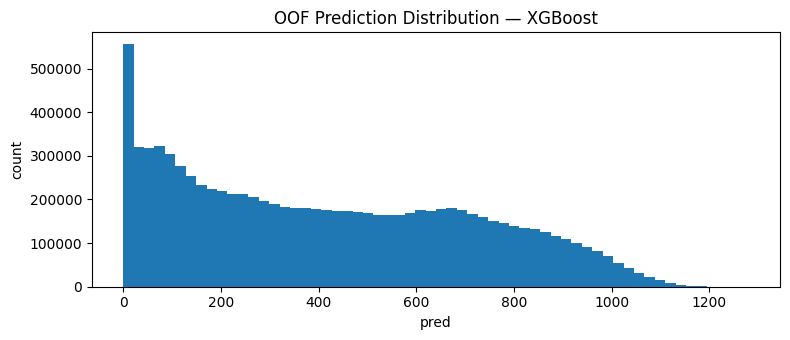

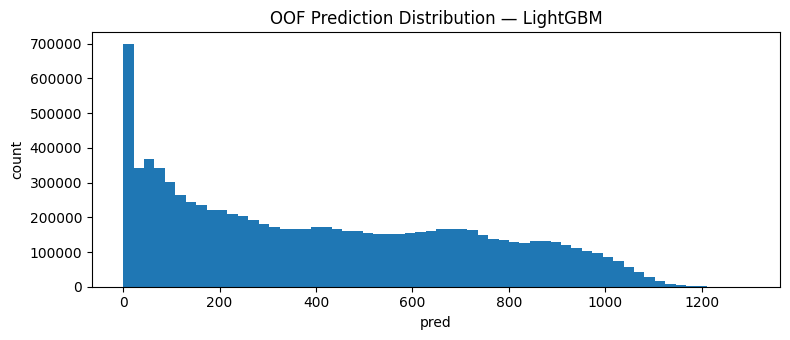

In [32]:
#📈 상위 N개 모델 OOF 예측 분포(퀵 체크)
# res_objects에 각 모델의 oof_pred가 저장되어 있다고 가정 (앞에서 그렇게 저장했음)
topN = 2  # 상위 2개 모델만 예시
tops = df_model_cmp.sort_values("oof_mae")["model"].head(topN).tolist()

for m in tops:
    preds = res_objects[m]["oof_pred"]
    plt.figure(figsize=(8,3.5))
    plt.hist(preds, bins=60)
    plt.title(f"OOF Prediction Distribution — {m}")
    plt.xlabel("pred")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


In [33]:
#🧪 폴드별 MAE 테이블 (상위 1~2개 모델)
rows = []
for m in df_model_cmp.sort_values("oof_mae")["model"].head(2):
    fm = res_objects[m]["fold_mae"]
    for i, mae in enumerate(fm, 1):
        rows.append({"model": m, "fold": i, "mae": mae})
df_folds = pd.DataFrame(rows).pivot(index="fold", columns="model", values="mae").round(3)
display(df_folds)


model  LightGBM  XGBoost
fold                    
1        99.386   98.014
2       101.980  100.300
3        99.440   98.022
4        98.436   97.674
5        99.095   98.343

In [34]:
#========================================
# 5) 실행 루프(샘플 × 모델 × 폴드)
#각 샘플에 대해 아래를 반복:
#1. **모델 학습/검증**: 공통 폴드로 OOF 예측 수행.
#2. **로깅**:
#    - 메타: 날짜, seed, 샘플 pv 개수/행 수, 야간 정책, 파생 버전, 피처 리스트 해시
#    - 모델: 이름, 핵심 하이퍼, 폴드별 MAE, **OOF 평균 MAE**, 훈련시간
#3. **아티팩트**(선택): OOF 예측 벡터 저장(후속 앙상블/스태킹 대비).
#============================================
#🧱 S5-0 — 실행/로깅 설정
# 실행/저장 옵션
SAVE_OOF = True                # 각 (샘플,모델) OOF 벡터 저장할지
OOF_DIR  = "oof_runs"          # OOF 저장 폴더
LOG_CSV  = "runs_log.csv"      # 집계 로그(추가 기록, append)

# 메타 읽기(락 파일)
import json, os, hashlib, datetime, numpy as np, pandas as pd
from typing import Dict, Any

with open("features_lock_train.json","r",encoding="utf-8") as f:
    lock = json.load(f)

NIGHT_POLICY      = lock.get("night_policy","uv")
DERIVED_FEATURES  = lock.get("derived_features", [])
MODEL_FEATURE_SRC = lock.get("model_feature_sources", [])
SOURCE_ONLY       = lock.get("source_only", [])
FEATURE_COLS_LOCK = lock.get("feature_cols", [])

os.makedirs(OOF_DIR, exist_ok=True)

def hash_cols(cols) -> str:
    """피처 리스트 해시(재현성/버전 추적)."""
    s = "\n".join(map(str, cols))
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:10]

FEATURE_HASH = hash_cols(FEATURE_COLS_LOCK)
RUN_DATE     = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


In [37]:
#🧩 S5-1 — 한 샘플을 평가→로그로 남기는 함수
# 이미 위 셀에서 임포트/유틸이 있다면 중복 임포트는 무시돼요
import time, json, os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone

# 메타 컬럼 제외 + 전 컬럼 숫자형 강제
META_COLS = ["pv_id", "type", "energy", "nins"]
def make_numeric_X(df: pd.DataFrame, drop_meta: bool = True) -> pd.DataFrame:
    X = df.copy()
    if drop_meta:
        X = X.drop(columns=[c for c in META_COLS if c in X.columns], errors="ignore")
    # 카테고리는 코드로, 비수치형은 드롭
    for c in list(X.columns):
        if isinstance(X[c].dtype, pd.CategoricalDtype):
            X[c] = X[c].cat.codes.astype("int32")
        elif not pd.api.types.is_numeric_dtype(X[c]):
            X = X.drop(columns=[c])
    return X.astype("float32")

def evaluate_one_sample(pack: dict, model_suite: dict) -> pd.DataFrame:
    """
    pack: sampling_generator가 만든 dict
      - sample_id, frac, seed, n_pv, n_pv_total, X, y, groups
    """
    sid, frac, seed = pack["sample_id"], pack["frac"], pack["seed"]
    Xs, ys, gs      = pack["X"], pack["y"], pack["groups"]

    # ✅ 추가: 입력을 숫자형으로 강제(메타/문자열 제거)
    Xs = make_numeric_X(Xs, drop_meta=True)

    # 공통 folds (이 샘플에서 고정, 모든 모델 공유)
    gkf = GroupKFold(n_splits=5)
    idx = np.arange(len(gs))
    folds = [(tr, va) for tr, va in gkf.split(idx, groups=gs)]

    logs = []
    for mname, est in model_suite.items():
        print(f"\n[{sid}] model={mname}  rows={len(Xs)}  feats={Xs.shape[1]}")
        t0 = time.time()

        oof = np.full(len(Xs), np.nan, dtype=np.float32)
        f_mae, f_time = [], []
        for i, (tr, va) in enumerate(folds, 1):
            m = clone(est)
            tr_X, tr_y = Xs.iloc[tr], ys.iloc[tr]
            va_X, va_y = Xs.iloc[va], ys.iloc[va]

            tt = time.time()
            m.fit(tr_X, tr_y)
            f_time.append(time.time() - tt)

            pred = m.predict(va_X).astype(np.float32)
            pred = np.clip(pred, 0.0, None)  # 물리 제약

            oof[va] = pred
            mae = mean_absolute_error(va_y.values, pred)
            f_mae.append(mae)
            print(f"  - Fold {i}: MAE={mae:.4f}  n_tr={len(tr)} n_va={len(va)}  fit_time={f_time[-1]:.2f}s")

        oof_mae = mean_absolute_error(ys.values, oof)
        pred_stats = {
            "min": float(np.nanmin(oof)),
            "max": float(np.nanmax(oof)),
            "mean": float(np.nanmean(oof)),
            "std":  float(np.nanstd(oof)),
            "neg_clip_ratio": float(np.mean(oof == 0.0)),
        }
        print(f"  => OOF MAE={oof_mae:.4f}  total_fit_time={sum(f_time):.2f}s")

        # (선택) 저장 옵션 쓰는 경우
        oof_path = ""
        if SAVE_OOF:
            oof_path = os.path.join(OOF_DIR, f"oof_{sid}_{mname}.npy")
            np.save(oof_path, oof)

        # 핵심 하이퍼만 요약
        try:
            params = clone(est).get_params()
            key_params = {k: params[k] for k in params if k in [
                "n_estimators","max_depth","num_leaves","learning_rate",
                "subsample","colsample_bytree","min_child_samples","min_child_weight",
                "alpha","lambda","reg_alpha","reg_lambda","tol"
            ]}
        except Exception:
            key_params = {}

        logs.append({
            "run_date": RUN_DATE,
            "sample_id": sid,
            "seed": seed,
            "frac": float(frac),
            "n_pv": int(pack["n_pv"]),
            "n_pv_total": int(pack["n_pv_total"]),
            "n_rows": int(len(Xs)),
            "night_policy": NIGHT_POLICY,
            "feature_hash": FEATURE_HASH,
            "n_features": int(Xs.shape[1]),
            "model": mname,
            "key_params": json.dumps(key_params, ensure_ascii=False),
            "fold_mae_mean": float(np.mean(f_mae)),
            "fold_mae_std":  float(np.std(f_mae)),
            "oof_mae": float(oof_mae),
            "fit_time_sum": float(np.sum(f_time)),
            "pred_min": pred_stats["min"],
            "pred_max": pred_stats["max"],
            "pred_mean": pred_stats["mean"],
            "pred_std": pred_stats["std"],
            "neg_clip_ratio": pred_stats["neg_clip_ratio"],
            "oof_path": oof_path,
        })

    return pd.DataFrame(logs)


In [38]:
#🚀 S5-2 — 전체 실행 루프(샘플러 전 조합)
# 샘플러는 Step 2에서 정의한 sampling_generator를 그대로 사용
gen_all = sampling_generator(
    train_final, y_train, groups_train,
    fractions=FRACTIONS, seeds=SEEDS,
    id_col="pv_id", target_col="nins",
    feature_lock_path="features_lock_train.json"
)

all_logs = []
for pack in gen_all:
    df_log = evaluate_one_sample(pack, model_suite)
    all_logs.append(df_log)

# 이번 러닝의 결과 묶음
run_log = pd.concat(all_logs, axis=0, ignore_index=True)
run_log = run_log.sort_values(["oof_mae","model","sample_id"]).reset_index(drop=True)
display(run_log.head(10))
print("=== Completed:", run_log.shape)


C:\Users\alexs\AppData\Local\Temp\ipykernel_15968\1441266673.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[id_col]):



[frac0.20_seed0] model=RandomForest  rows=1837356  feats=25
  - Fold 1: MAE=120.3271  n_tr=1440204 n_va=397152  fit_time=128.08s
  - Fold 2: MAE=121.6413  n_tr=1489440 n_va=347916  fit_time=136.45s
  - Fold 3: MAE=125.9082  n_tr=1489452 n_va=347904  fit_time=133.66s
  - Fold 4: MAE=118.8189  n_tr=1440876 n_va=396480  fit_time=130.96s
  - Fold 5: MAE=117.1833  n_tr=1489452 n_va=347904  fit_time=134.73s
  => OOF MAE=120.7120  total_fit_time=663.87s

[frac0.20_seed0] model=ExtraTrees  rows=1837356  feats=25
  - Fold 1: MAE=135.5418  n_tr=1440204 n_va=397152  fit_time=43.59s
  - Fold 2: MAE=137.2870  n_tr=1489440 n_va=347916  fit_time=44.65s
  - Fold 3: MAE=138.4294  n_tr=1489452 n_va=347904  fit_time=44.80s
  - Fold 4: MAE=135.8246  n_tr=1440876 n_va=396480  fit_time=43.07s
  - Fold 5: MAE=134.0815  n_tr=1489452 n_va=347904  fit_time=45.04s
  => OOF MAE=136.2036  total_fit_time=221.15s

[frac0.20_seed0] model=Ridge  rows=1837356  feats=25
  - Fold 1: MAE=133.3564  n_tr=1440204 n_va=39715

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+09, tolerance: 1.592e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=133.3563  n_tr=1440204 n_va=397152  fit_time=158.01s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+09, tolerance: 1.640e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=132.8984  n_tr=1489440 n_va=347916  fit_time=170.40s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.230e+09, tolerance: 1.665e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=136.8804  n_tr=1489452 n_va=347904  fit_time=170.10s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e+09, tolerance: 1.590e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=133.9339  n_tr=1440876 n_va=396480  fit_time=156.85s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+09, tolerance: 1.650e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=130.3430  n_tr=1489452 n_va=347904  fit_time=168.94s
  => OOF MAE=133.4910  total_fit_time=824.30s

[frac0.20_seed0] model=LightGBM  rows=1837356  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 1440204, number of used features: 25
[LightGBM] [Info] Start training from score 346.796326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.359e+09, tolerance: 1.631e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=136.7728  n_tr=1490232 n_va=348108  fit_time=165.33s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+09, tolerance: 1.613e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=140.7958  n_tr=1490244 n_va=348096  fit_time=158.49s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e+09, tolerance: 1.568e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=137.4510  n_tr=1441644 n_va=396696  fit_time=163.14s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e+09, tolerance: 1.645e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=129.7779  n_tr=1490268 n_va=348072  fit_time=169.08s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.323e+09, tolerance: 1.606e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=126.7745  n_tr=1440972 n_va=397368  fit_time=156.08s
  => OOF MAE=134.1953  total_fit_time=812.11s

[frac0.20_seed1] model=LightGBM  rows=1838340  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4341
[LightGBM] [Info] Number of data points in the train set: 1490232, number of used features: 25
[LightGBM] [Info] Start training from score 343.561859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+09, tolerance: 1.671e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=126.7974  n_tr=1488360 n_va=347616  fit_time=168.51s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+09, tolerance: 1.652e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=135.9236  n_tr=1488348 n_va=347628  fit_time=169.29s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e+09, tolerance: 1.648e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=134.6645  n_tr=1488336 n_va=347640  fit_time=162.51s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+09, tolerance: 1.612e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=140.1260  n_tr=1439100 n_va=396876  fit_time=155.27s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+09, tolerance: 1.592e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=2085.2034  n_tr=1439760 n_va=396216  fit_time=157.60s
  => OOF MAE=555.5334  total_fit_time=813.18s

[frac0.20_seed2] model=LightGBM  rows=1835976  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4346
[LightGBM] [Info] Number of data points in the train set: 1488360, number of used features: 25
[LightGBM] [Info] Start training from score 354.692810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.401e+09, tolerance: 1.716e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=133.6154  n_tr=1490760 n_va=348192  fit_time=162.70s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+09, tolerance: 1.653e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=141.3819  n_tr=1442148 n_va=396804  fit_time=157.66s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e+09, tolerance: 1.705e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=133.8408  n_tr=1490748 n_va=348204  fit_time=163.90s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+09, tolerance: 1.685e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=143.1665  n_tr=1490676 n_va=348276  fit_time=168.13s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e+09, tolerance: 1.662e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=135.2472  n_tr=1441476 n_va=397476  fit_time=158.82s
  => OOF MAE=137.4955  total_fit_time=811.20s

[frac0.20_seed3] model=LightGBM  rows=1838952  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4334
[LightGBM] [Info] Number of data points in the train set: 1490760, number of used features: 25
[LightGBM] [Info] Start training from score 353.524536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.422e+08, tolerance: 1.662e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=127.3339  n_tr=1440120 n_va=396300  fit_time=159.90s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.637e+08, tolerance: 1.649e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=140.8572  n_tr=1488672 n_va=347748  fit_time=167.70s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e+09, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=125.8573  n_tr=1439424 n_va=396996  fit_time=158.12s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+09, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=134.5534  n_tr=1488732 n_va=347688  fit_time=169.28s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.027e+08, tolerance: 1.664e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=137.8691  n_tr=1488732 n_va=347688  fit_time=168.36s
  => OOF MAE=132.9370  total_fit_time=823.35s

[frac0.20_seed4] model=LightGBM  rows=1836420  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4331
[LightGBM] [Info] Number of data points in the train set: 1440120, number of used features: 25
[LightGBM] [Info] Start training from score 358.720001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e+09, tolerance: 2.445e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=133.1075  n_tr=2184756 n_va=546348  fit_time=258.74s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e+09, tolerance: 2.415e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=134.0053  n_tr=2184696 n_va=546408  fit_time=253.96s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e+09, tolerance: 2.423e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=133.5583  n_tr=2185380 n_va=545724  fit_time=252.12s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e+09, tolerance: 2.425e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=139.5583  n_tr=2184792 n_va=546312  fit_time=252.33s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+09, tolerance: 2.427e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=135.3091  n_tr=2184792 n_va=546312  fit_time=252.72s
  => OOF MAE=135.1080  total_fit_time=1269.86s

[frac0.30_seed0] model=LightGBM  rows=2731104  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4369
[LightGBM] [Info] Number of data points in the train set: 2184756, number of used features: 25
[LightGBM] [Info] Start training from score 347.804993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e+09, tolerance: 2.372e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=137.4208  n_tr=2187192 n_va=546192  fit_time=254.44s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e+09, tolerance: 2.350e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=134.4591  n_tr=2186520 n_va=546864  fit_time=254.78s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e+09, tolerance: 2.396e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=134.9860  n_tr=2186652 n_va=546732  fit_time=255.19s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e+09, tolerance: 2.383e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=130.5327  n_tr=2186520 n_va=546864  fit_time=247.30s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+09, tolerance: 2.406e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=129.4806  n_tr=2186652 n_va=546732  fit_time=256.59s
  => OOF MAE=133.3749  total_fit_time=1268.30s

[frac0.30_seed1] model=LightGBM  rows=2733384  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4366
[LightGBM] [Info] Number of data points in the train set: 2187192, number of used features: 25
[LightGBM] [Info] Start training from score 343.601379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e+09, tolerance: 2.444e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=137.8856  n_tr=2183784 n_va=546144  fit_time=253.81s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+09, tolerance: 2.424e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=134.6156  n_tr=2183820 n_va=546108  fit_time=254.38s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e+09, tolerance: 2.413e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=134.6000  n_tr=2183880 n_va=546048  fit_time=242.23s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e+09, tolerance: 2.488e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=126.7392  n_tr=2183796 n_va=546132  fit_time=253.89s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e+09, tolerance: 2.412e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=136.5595  n_tr=2184432 n_va=545496  fit_time=253.25s
  => OOF MAE=134.0794  total_fit_time=1257.55s

[frac0.30_seed2] model=LightGBM  rows=2729928  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4358
[LightGBM] [Info] Number of data points in the train set: 2183784, number of used features: 25
[LightGBM] [Info] Start training from score 352.373322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+09, tolerance: 2.458e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=132.6168  n_tr=2184456 n_va=546336  fit_time=249.66s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e+09, tolerance: 2.451e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=136.9808  n_tr=2185080 n_va=545712  fit_time=254.95s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+09, tolerance: 2.434e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=139.2914  n_tr=2184564 n_va=546228  fit_time=254.23s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e+09, tolerance: 2.438e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=134.1878  n_tr=2184528 n_va=546264  fit_time=254.92s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+09, tolerance: 2.479e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=132.5970  n_tr=2184540 n_va=546252  fit_time=243.18s
  => OOF MAE=135.1343  total_fit_time=1256.93s

[frac0.30_seed3] model=LightGBM  rows=2730792  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4358
[LightGBM] [Info] Number of data points in the train set: 2184456, number of used features: 25
[LightGBM] [Info] Start training from score 348.950012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e+09, tolerance: 2.450e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=138.3701  n_tr=2183688 n_va=546132  fit_time=255.55s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.391e+09, tolerance: 2.515e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=129.8369  n_tr=2183724 n_va=546096  fit_time=256.86s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e+09, tolerance: 2.492e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=135.9519  n_tr=2183712 n_va=546108  fit_time=251.76s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e+09, tolerance: 2.481e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=132.4825  n_tr=2183736 n_va=546084  fit_time=256.20s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e+09, tolerance: 2.453e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=137.1767  n_tr=2184420 n_va=545400  fit_time=254.15s
  => OOF MAE=134.7631  total_fit_time=1274.51s

[frac0.30_seed4] model=LightGBM  rows=2729820  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4355
[LightGBM] [Info] Number of data points in the train set: 2183688, number of used features: 25
[LightGBM] [Info] Start training from score 346.440002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.589e+09, tolerance: 3.280e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=133.3980  n_tr=2881932 n_va=745272  fit_time=318.70s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e+09, tolerance: 3.294e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=138.1309  n_tr=2931168 n_va=696036  fit_time=321.81s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.740e+09, tolerance: 3.315e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=133.0050  n_tr=2931192 n_va=696012  fit_time=314.60s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.922e+09, tolerance: 3.252e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=434.7815  n_tr=2881920 n_va=745284  fit_time=318.78s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.626e+09, tolerance: 3.231e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=137.3461  n_tr=2882604 n_va=744600  fit_time=318.62s
  => OOF MAE=196.9667  total_fit_time=1592.52s

[frac0.40_seed0] model=LightGBM  rows=3627204  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4389
[LightGBM] [Info] Number of data points in the train set: 2881932, number of used features: 25
[LightGBM] [Info] Start training from score 348.490173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.556e+09, tolerance: 3.131e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=131.7297  n_tr=2881848 n_va=744456  fit_time=285.11s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+09, tolerance: 3.142e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=132.0473  n_tr=2881176 n_va=745128  fit_time=287.33s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.389e+09, tolerance: 3.143e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=136.7759  n_tr=2930460 n_va=695844  fit_time=292.68s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e+09, tolerance: 3.122e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=132.7580  n_tr=2881296 n_va=745008  fit_time=284.83s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.525e+09, tolerance: 3.194e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=130.2228  n_tr=2930436 n_va=695868  fit_time=293.28s
  => OOF MAE=132.6853  total_fit_time=1443.23s

[frac0.40_seed1] model=LightGBM  rows=3626304  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4388
[LightGBM] [Info] Number of data points in the train set: 2881848, number of used features: 25
[LightGBM] [Info] Start training from score 344.188354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.588e+09, tolerance: 3.230e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=136.5183  n_tr=2881104 n_va=744276  fit_time=317.81s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.682e+09, tolerance: 3.246e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=132.0390  n_tr=2929704 n_va=695676  fit_time=321.21s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.563e+09, tolerance: 3.164e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=136.0970  n_tr=2880552 n_va=744828  fit_time=307.85s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.543e+09, tolerance: 3.186e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=135.8524  n_tr=2880444 n_va=744936  fit_time=318.88s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.649e+09, tolerance: 3.270e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=131.5560  n_tr=2929716 n_va=695664  fit_time=321.08s
  => OOF MAE=134.4832  total_fit_time=1586.84s

[frac0.40_seed2] model=LightGBM  rows=3625380  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 2881104, number of used features: 25
[LightGBM] [Info] Start training from score 351.630920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.737e+09, tolerance: 3.353e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=135.1507  n_tr=2930052 n_va=695736  fit_time=321.36s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e+09, tolerance: 3.219e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=143.7762  n_tr=2881440 n_va=744348  fit_time=306.38s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+09, tolerance: 3.340e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=132.7440  n_tr=2930040 n_va=695748  fit_time=320.69s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e+09, tolerance: 3.259e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=134.6767  n_tr=2880792 n_va=744996  fit_time=316.89s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+09, tolerance: 3.254e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=135.0168  n_tr=2880828 n_va=744960  fit_time=318.50s
  => OOF MAE=136.3347  total_fit_time=1583.83s

[frac0.40_seed3] model=LightGBM  rows=3625788  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4375
[LightGBM] [Info] Number of data points in the train set: 2930052, number of used features: 25
[LightGBM] [Info] Start training from score 348.820312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.713e+09, tolerance: 3.257e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 1: MAE=138.2329  n_tr=2928492 n_va=695364  fit_time=327.68s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e+09, tolerance: 3.274e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 2: MAE=135.6445  n_tr=2928492 n_va=695364  fit_time=318.63s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+09, tolerance: 3.188e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 3: MAE=131.7751  n_tr=2879244 n_va=744612  fit_time=317.13s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e+09, tolerance: 3.197e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 4: MAE=135.5568  n_tr=2879316 n_va=744540  fit_time=317.09s


C:\Users\alexs\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+09, tolerance: 3.230e+07
  model = cd_fast.enet_coordinate_descent(


  - Fold 5: MAE=130.1481  n_tr=2879880 n_va=743976  fit_time=324.64s
  => OOF MAE=134.1997  total_fit_time=1605.17s

[frac0.40_seed4] model=LightGBM  rows=3623856  feats=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 2928492, number of used features: 25
[LightGBM] [Info] Start training from score 349.239990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

run_date       sample_id  seed  frac  n_pv  n_pv_total   n_rows  \
0  2025-11-09 01:54:11  frac0.20_seed4     4   0.2    37         183  1836420   
1  2025-11-09 01:54:11  frac0.30_seed2     2   0.3    55         183  2729928   
2  2025-11-09 01:54:11  frac0.40_seed3     3   0.4    73         183  3625788   
3  2025-11-09 01:54:11  frac0.40_seed1     1   0.4    73         183  3626304   
4  2025-11-09 01:54:11  frac0.30_seed3     3   0.3    55         183  2730792   
5  2025-11-09 01:54:11  frac0.30_seed4     4   0.3    55         183  2729820   
6  2025-11-09 01:54:11  frac0.20_seed4     4   0.2    37         183  1836420   
7  2025-11-09 01:54:11  frac0.40_seed4     4   0.4    73         183  3623856   
8  2025-11-09 01:54:11  frac0.40_seed1     1   0.4    73         183  3626304   
9  2025-11-09 01:54:11  frac0.20_seed3     3   0.2    37         183  1838952   

  night_policy feature_hash  n_features  ... fold_mae_mean fold_mae_std  \
0           uv   0447c8090c          25  ...    102.904144     3.506404   
1           uv   0447c8090c          25  ...    102.897485     4.755217   
2           uv   0447c8090c          25  ...    102.973965     4.085097   
3           uv   0447c8090c          25  ...    103.378728     1.447320   
4           uv   0447c8090c          25  ...    104.033281     3.919966   
5           uv   0447c8090c          25  ...    104.221390     3.461205   
6           uv   0447c8090c          25  ...    104.328345     2.617415   
7           uv   0447c8090c          25  ...    104.551299     4.793717   
8           uv   0447c8090c          25  ...    104.496346     1.564744   
9           uv   0447c8090c          25  ...    104.468497     5.470246   

      oof_mae  fit_time_sum  pred_min     pred_max   pred_mean    pred_std  \
0  102.835175    128.793771       0.0  1261.013794  415.923187  301.177643   
1  102.896896    176.862278       0.0  1244.025391  415.670380  297.606537   
2  103.087715    234.355408       0.0  1278.362305  419.530243  303.519409   
3  103.404961    334.215588       0.0  1200.324707  413.151184  296.560028   
4  104.032951    177.421860       0.0  1269.452759  418.052643  301.857300   
5  104.221848    179.575248       0.0  1248.176392  418.073212  303.308990   
6  104.272469    173.971284       0.0  1248.221436  422.361176  317.898407   
7  104.463028    230.028876       0.0  1269.405518  416.593292  300.372314   
8  104.501732    449.420022       0.0  1211.477051  415.992065  312.516174   
9  104.567421    120.375844       0.0  1279.621338  424.417816  305.135132   

   neg_clip_ratio                                  oof_path  
0        0.024274   oof_runs\oof_frac0.20_seed4_XGBoost.npy  
1        0.021404   oof_runs\oof_frac0.30_seed2_XGBoost.npy  
2        0.022823   oof_runs\oof_frac0.40_seed3_XGBoost.npy  
3        0.023028   oof_runs\oof_frac0.40_seed1_XGBoost.npy  
4        0.022533   oof_runs\oof_frac0.30_seed3_XGBoost.npy  
5        0.025163   oof_runs\oof_frac0.30_seed4_XGBoost.npy  
6        0.016170  oof_runs\oof_frac0.20_seed4_LightGBM.npy  
7        0.022642   oof_runs\oof_frac0.40_seed4_XGBoost.npy  
8        0.013868  oof_runs\oof_frac0.40_seed1_LightGBM.npy  
9        0.020823   oof_runs\oof_frac0.20_seed3_XGBoost.npy  

[10 rows x 22 columns]

=== Completed: (90, 22)


In [39]:
#💾 S5-3 — 로그 CSV에 “추가 기록(append)”
# 기존 파일이 있으면 append, 없으면 header 포함 저장
if os.path.exists(LOG_CSV):
    run_log.to_csv(LOG_CSV, mode="a", header=False, index=False, encoding="utf-8")
else:
    run_log.to_csv(LOG_CSV, index=False, encoding="utf-8")

print(f"[saved] {LOG_CSV}  (+{len(run_log)} rows)")


[saved] runs_log.csv  (+90 rows)


In [40]:
#===========================
## 6) 1차 선정(샘플 간 종합 평가)
#1. **모델별 집계**: 샘플 반복 결과를 **평균 MAE**와 **표준편차**로 요약.
#2. **1차 순위**: 평균 MAE가 낮고, 표준편차가 작은 모델 우선.
#3. **유의성 점검(선택)**: 상위 2개 모델의 폴드 스코어로 간단한 대응 t-test/윌콕슨.
#4. **결정**: **Top-1~3** 모델을 후보로 확정.
#============================
#🧩 셀 1 — 데이터 불러오기
# ==============================================
# 📗 Step 6-1: 데이터 불러오기
# ==============================================

import pandas as pd
import numpy as np
from scipy import stats

# 저장된 러닝 결과 불러오기 (파일명은 예시)
df = pd.read_csv("runs_log.csv")

print(f"✅ Loaded {len(df)} rows from runs_log.csv")
display(df.head())


✅ Loaded 90 rows from runs_log.csv


run_date       sample_id  seed  frac  n_pv  n_pv_total   n_rows  \
0  2025-11-09 01:54:11  frac0.20_seed4     4   0.2    37         183  1836420   
1  2025-11-09 01:54:11  frac0.30_seed2     2   0.3    55         183  2729928   
2  2025-11-09 01:54:11  frac0.40_seed3     3   0.4    73         183  3625788   
3  2025-11-09 01:54:11  frac0.40_seed1     1   0.4    73         183  3626304   
4  2025-11-09 01:54:11  frac0.30_seed3     3   0.3    55         183  2730792   

  night_policy feature_hash  n_features  ... fold_mae_mean fold_mae_std  \
0           uv   0447c8090c          25  ...    102.904144     3.506404   
1           uv   0447c8090c          25  ...    102.897485     4.755217   
2           uv   0447c8090c          25  ...    102.973965     4.085097   
3           uv   0447c8090c          25  ...    103.378728     1.447320   
4           uv   0447c8090c          25  ...    104.033281     3.919966   

      oof_mae  fit_time_sum  pred_min     pred_max   pred_mean    pred_std  \
0  102.835175    128.793771       0.0  1261.013794  415.923187  301.177643   
1  102.896896    176.862278       0.0  1244.025391  415.670380  297.606537   
2  103.087715    234.355408       0.0  1278.362305  419.530243  303.519409   
3  103.404961    334.215588       0.0  1200.324707  413.151184  296.560028   
4  104.032951    177.421860       0.0  1269.452759  418.052643  301.857300   

   neg_clip_ratio                                 oof_path  
0        0.024274  oof_runs\oof_frac0.20_seed4_XGBoost.npy  
1        0.021404  oof_runs\oof_frac0.30_seed2_XGBoost.npy  
2        0.022823  oof_runs\oof_frac0.40_seed3_XGBoost.npy  
3        0.023028  oof_runs\oof_frac0.40_seed1_XGBoost.npy  
4        0.022533  oof_runs\oof_frac0.30_seed3_XGBoost.npy  

[5 rows x 22 columns]

In [41]:
#🧩 셀 2 — 모델별 성능 집계 (평균, 표준편차, 개수)
# ==============================================
# 📘 Step 6-2: 모델별 MAE 요약 통계
# ==============================================

agg = (
    df.groupby("model")["oof_mae"]
      .agg(["mean", "std", "count"])
      .rename(columns={"mean": "mae_mean", "std": "mae_std"})
      .sort_values("mae_mean")
)

# 보기 좋게 반올림
agg["mae_mean"] = agg["mae_mean"].round(3)
agg["mae_std"]  = agg["mae_std"].round(3)

print("📊 모델별 평균 MAE 및 표준편차")
display(agg)


📊 모델별 평균 MAE 및 표준편차


mae_mean  mae_std  count
model                                 
XGBoost        105.047    1.801     15
LightGBM       106.606    1.545     15
RandomForest   121.560    1.078     15
ExtraTrees     137.420    1.231     15
Lasso          166.719  108.766     15
Ridge          166.799  109.025     15

In [42]:
#🧩 셀 3 — 1차 순위 계산 (정확도 + 안정성)
# ==============================================
# 📙 Step 6-3: 1차 순위 계산 (MAE + 안정성 반영)
# ==============================================

# rank_score = 평균 MAE + (표준편차 * 가중치)
agg["rank_score"] = (agg["mae_mean"] + 0.2 * agg["mae_std"]).round(3)
agg = agg.sort_values("rank_score")

print("🏅 1차 순위 (MAE + 안정성 반영)")
display(agg.head(5))


🏅 1차 순위 (MAE + 안정성 반영)


mae_mean  mae_std  count  rank_score
model                                             
XGBoost        105.047    1.801     15     105.407
LightGBM       106.606    1.545     15     106.915
RandomForest   121.560    1.078     15     121.776
ExtraTrees     137.420    1.231     15     137.666
Lasso          166.719  108.766     15     188.472

In [43]:
#🧩 셀 4 — 상위 2개 모델 유의성 검정 (t-test & Wilcoxon)
# ==============================================
# 📒 Step 6-4: 상위 2개 모델 간 유의성 검정
# ==============================================

top2 = agg.head(2).index.tolist()

if len(top2) == 2:
    model_a, model_b = top2
    a_scores = df.loc[df["model"] == model_a, "oof_mae"].values
    b_scores = df.loc[df["model"] == model_b, "oof_mae"].values

    print(f"🔬 상위 2개 모델 비교: {model_a} vs {model_b}")

    # t-test (대응 또는 독립표본 자동)
    if len(a_scores) == len(b_scores):
        t_stat, p_val = stats.ttest_rel(a_scores, b_scores)
        print(f"Paired t-test → t={t_stat:.3f}, p={p_val:.4f}")
    else:
        t_stat, p_val = stats.ttest_ind(a_scores, b_scores, equal_var=False)
        print(f"Independent t-test → t={t_stat:.3f}, p={p_val:.4f}")

    # 비모수 윌콕슨 검정
    try:
        if len(a_scores) == len(b_scores):
            w_stat, w_p = stats.wilcoxon(a_scores, b_scores)
            print(f"Wilcoxon test → W={w_stat:.3f}, p={w_p:.4f}")
    except Exception as e:
        print("(Wilcoxon test skipped — 데이터 크기 불일치)")


🔬 상위 2개 모델 비교: XGBoost vs LightGBM
Paired t-test → t=-13.681, p=0.0000
Wilcoxon test → W=0.000, p=0.0001


In [44]:
#🧩 셀 5 — 최종 후보 확정 + 결과 저장
# ==============================================
# 📕 Step 6-5: 최종 후보 모델 확정 및 저장
# ==============================================

top3 = agg.head(3).index.tolist()
print("\n✅ 1차 후보 모델:", ", ".join(top3))

# 결과 저장 (선택)
agg.to_csv("runs_summary_step6.csv", index=True, encoding="utf-8-sig")
print("💾 Saved summary → runs_summary_step6.csv")



✅ 1차 후보 모델: XGBoost, LightGBM, RandomForest
💾 Saved summary → runs_summary_step6.csv


In [45]:
#=========================
# 7) (선택) 간단 앙상블 검증
#- **조건**: 상위 모델들의 MAE가 비슷하고 오차 상관이 낮아 보일 때.
#- **방법**: 같은 폴드에서 **단순 평균**/ **역-MAE 가중 평균**으로 OOF 앙상블 스코어 산출 → 단일 모델 대비 개선 시 최종 후보에 포함.
#============================
#🧩 셀 1 — OOF 예측 불러오기
# ==============================================
# 📗 Step 7-1: 상위 모델 OOF 결과 불러오기
# ==============================================

import numpy as np
import pandas as pd
import os

# Step 6에서 상위 모델 3개를 확정했었죠
top_models = ["XGBoost", "LightGBM", "RandomForest"]

# run_log 파일 다시 불러오기 (oof_path 정보가 필요)
df = pd.read_csv("runs_log.csv")

# 각 상위 모델의 oof 파일 경로만 추출
paths = df.loc[df["model"].isin(top_models), ["model", "oof_path"]]

print("🔍 불러올 OOF 파일 수:", len(paths))
display(paths.head())

# 모델별 예측값 dict 생성
oof_preds = {}
for model, path in zip(paths["model"], paths["oof_path"]):
    if os.path.exists(path):
        oof_preds[model] = np.load(path)
    else:
        print(f"⚠️ 파일 없음: {path}")

for k, v in oof_preds.items():
    print(f"{k}: shape={v.shape}, mean={v.mean():.3f}")


🔍 불러올 OOF 파일 수: 45


model                                 oof_path
0  XGBoost  oof_runs\oof_frac0.20_seed4_XGBoost.npy
1  XGBoost  oof_runs\oof_frac0.30_seed2_XGBoost.npy
2  XGBoost  oof_runs\oof_frac0.40_seed3_XGBoost.npy
3  XGBoost  oof_runs\oof_frac0.40_seed1_XGBoost.npy
4  XGBoost  oof_runs\oof_frac0.30_seed3_XGBoost.npy

XGBoost: shape=(1838340,), mean=417.125
LightGBM: shape=(2731104,), mean=418.053
RandomForest: shape=(1838952,), mean=423.042


In [46]:
#🧩 셀 2 — 단순 앙상블 (평균 OOF)
# ==============================================
# 📘 Step 7-2: 단순 평균 앙상블 (Simple Average)
# ==============================================

# 공통 길이만큼 자르기
min_len = min(len(v) for v in oof_preds.values())
arr = np.vstack([v[:min_len] for v in oof_preds.values()])

# 단순 평균 앙상블
ensemble_simple = arr.mean(axis=0)

print(f"단순 평균 앙상블 shape={ensemble_simple.shape}")


단순 평균 앙상블 shape=(1838340,)


In [47]:
#🧩 셀 3 — 역-MAE 가중 앙상블 (Weighted Average)
# ==============================================
# 📙 Step 7-3: 역-MAE 가중 앙상블 (Weighted Average)
# ==============================================

# 모델별 OOF MAE 값
mae_table = df.groupby("model")["oof_mae"].mean()
mae_sub = mae_table.loc[mae_table.index.isin(top_models)]
print(mae_sub)

# 역-MAE 가중치 계산 (값이 낮을수록 가중 큼)
weights = 1.0 / mae_sub
weights = weights / weights.sum()
print("\n가중치:")
print(weights)

# 앙상블 계산
weighted = np.zeros(min_len)
for m, w in weights.items():
    weighted += w * oof_preds[m][:min_len]

ensemble_weighted = weighted.copy()
print("✅ Weighted ensemble 완료")


model
LightGBM        106.605966
RandomForest    121.560049
XGBoost         105.046677
Name: oof_mae, dtype: float64

가중치:
model
LightGBM        0.345802
RandomForest    0.303262
XGBoost         0.350935
Name: oof_mae, dtype: float64
✅ Weighted ensemble 완료


In [49]:
#🧩 셀 4 — 성능 비교 (MAE 평가)
# ==============================================
# 📒 Step 7-4: 앙상블 성능 평가
# ==============================================

from sklearn.metrics import mean_absolute_error

# y_true 로드 (train_final과 동일 순서여야 함)
# 예시:
y_true = pd.read_csv("train.csv")["nins"].values[:min_len]

# 단일 모델 MAE
for m in top_models:
    mae = mean_absolute_error(y_true[:min_len], oof_preds[m][:min_len])
    print(f"{m:<15} MAE = {mae:.4f}")

# 앙상블 MAE
mae_simple = mean_absolute_error(y_true[:min_len], ensemble_simple)
mae_weight = mean_absolute_error(y_true[:min_len], ensemble_weighted)

print("\n🏁 Ensemble Results")
print(f"Simple Avg   MAE = {mae_simple:.4f}")
print(f"Weighted Avg MAE = {mae_weight:.4f}")


XGBoost         MAE = 389.9297
LightGBM        MAE = 393.5574
RandomForest    MAE = 389.5891

🏁 Ensemble Results
Simple Avg   MAE = 368.9030
Weighted Avg MAE = 368.9714


In [50]:
#🧩 셀 5 — 최종 판단 및 결과 저장
# ==============================================
# 📕 Step 7-5: 결과 요약 및 저장
# ==============================================

summary = {
    "Model": top_models + ["Ensemble_Simple", "Ensemble_Weighted"],
    "MAE": [
        mean_absolute_error(y_true[:min_len], oof_preds[top_models[0]][:min_len]),
        mean_absolute_error(y_true[:min_len], oof_preds[top_models[1]][:min_len]),
        mean_absolute_error(y_true[:min_len], oof_preds[top_models[2]][:min_len]),
        mae_simple,
        mae_weight
    ]
}
summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("MAE")
display(summary_df)

summary_df.to_csv("ensemble_eval_step7.csv", index=False, encoding="utf-8-sig")
print("💾 Saved → ensemble_eval_step7.csv")


Model         MAE
3    Ensemble_Simple  368.903035
4  Ensemble_Weighted  368.971364
2       RandomForest  389.589130
0            XGBoost  389.929668
1           LightGBM  393.557421

💾 Saved → ensemble_eval_step7.csv


In [51]:
#=================================
# 8) 최종 학습(풀데이터)
#1. **동일 파이프라인 재적용**(1단계 그대로).
#2. *최종 후보(단일 또는 앙상블)**를 **전체 학습 데이터**로 재학습.
#3. **파라미터 확장**: n_estimators↑, early stopping/monotone 제약 등 **소폭 확장**은 허용(정책에 기록).
#4. **검증 리포트**:
#    - 최종 모델(또는 앙상블) 파라미터 스냅샷
#    - 전체 학습 OOF MAE(있다면), 학습 로그 요약
#===================================
#🧩 셀 1 — 준비 (데이터, 후보 모델, 기본 파라미터)
# ==============================================
# 📗 Step 8-1: 데이터 및 모델 후보 세팅
# ==============================================
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

# 데이터 불러오기
train = pd.read_csv("train.csv")

# Feature / Target 분리
X = train.drop(columns=["nins", "time", "pv_id"], errors="ignore")
y = train["nins"]

print(f"✅ train shape: {X.shape}, target shape: {y.shape}")

# 최종 후보 모델들 (Step 7 결과 기준)
final_candidates = ["XGBoost", "RandomForest", "Ensemble_Simple"]


✅ train shape: (19236948, 30), target shape: (19236948,)


In [53]:
# ==============================================
# 🔧 해결: XGBoost용 데이터 타입 변환
# ==============================================
# object 타입 전부 변환
X = X.apply(lambda col: col.astype("category").cat.codes
            if col.dtype == "object" else col)

print("✅ 모든 object 컬럼을 category→codes로 변환 완료")
print(X.dtypes.value_counts())


✅ 모든 object 컬럼을 category→codes로 변환 완료
float64    29
int8        1
Name: count, dtype: int64


In [55]:
#🧩 셀 2 — 모델 학습 (Full-data)
# ==============================================
# 📘 Step 8-2: 개별 모델 Full-data 학습
# ==============================================

# ==============================================
# 🧩 Step 8-2: 개별 모델 Full-data 학습 (XGB + LGBM만)
# ==============================================
import joblib

# 💡 참고: X는 이미 수치형으로 변환되어 있어야 함
# X = X.apply(lambda col: col.astype("category").cat.codes if col.dtype == "object" else col)

print(f"학습 데이터 크기: X={X.shape}, y={y.shape}")

# ---------------------------
# 1️⃣ XGBoost Full-data 학습
# ---------------------------
xgb_model = xgb.XGBRegressor(
    n_estimators=2500,        # Step 5 대비 소폭 확장
    learning_rate=0.04,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    random_state=42,
    tree_method="hist",       # CPU/GPU 자동
    n_jobs=-1,
    verbosity=1
)

print("\n🚀 XGBoost 학습 시작...")
xgb_model.fit(X, y)
joblib.dump(xgb_model, "model_xgb_final.pkl")
print("✅ XGBoost 학습 완료 및 저장 → model_xgb_final.pkl")


# ---------------------------
# 2️⃣ LightGBM Full-data 학습
# ---------------------------
lgb_model = lgb.LGBMRegressor(
    n_estimators=2500,
    learning_rate=0.04,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=50,
    random_state=42,
    n_jobs=-1
)

print("\n🚀 LightGBM 학습 시작...")
lgb_model.fit(X, y)
joblib.dump(lgb_model, "model_lgb_final.pkl")
print("✅ LightGBM 학습 완료 및 저장 → model_lgb_final.pkl")


학습 데이터 크기: X=(19236948, 30), y=(19236948,)

🚀 XGBoost 학습 시작...
✅ XGBoost 학습 완료 및 저장 → model_xgb_final.pkl

🚀 LightGBM 학습 시작...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.627969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6876
[LightGBM] [Info] Number of data points in the train set: 19236948, number of used features: 29
[LightGBM] [Info] Start training from score 197.735051
✅ LightGBM 학습 완료 및 저장 → model_lgb_final.pkl


In [56]:
#🧩 셀 3 — 앙상블 예측 및 비교
# ==============================================
# 📙 Step 8-3: 최종 앙상블 검증
# ==============================================
# ==============================================
# 🧩 Step 8-3: 최종 앙상블 예측 및 비교 (XGB + LGBM)
# ==============================================
from sklearn.metrics import mean_absolute_error
import numpy as np

print("🚀 최종 앙상블 검증 시작...")

# 1️⃣ 개별 모델 예측
pred_xgb = xgb_model.predict(X)
pred_lgb = lgb_model.predict(X)

# 2️⃣ 단일 모델 성능 계산
mae_xgb = mean_absolute_error(y, pred_xgb)
mae_lgb = mean_absolute_error(y, pred_lgb)

print(f"XGBoost   MAE = {mae_xgb:.4f}")
print(f"LightGBM  MAE = {mae_lgb:.4f}")

# 3️⃣ 단순 평균 앙상블 (Simple Average)
pred_ens_simple = (pred_xgb + pred_lgb) / 2
mae_simple = mean_absolute_error(y, pred_ens_simple)
print(f"Simple Ensemble MAE = {mae_simple:.4f}")

# 4️⃣ 역-MAE 가중 앙상블 (Weighted Average)
weights = 1 / np.array([mae_xgb, mae_lgb])
weights /= weights.sum()

pred_ens_weighted = weights[0] * pred_xgb + weights[1] * pred_lgb
mae_weight = mean_absolute_error(y, pred_ens_weighted)
print(f"Weighted Ensemble MAE = {mae_weight:.4f}")

# 5️⃣ 결과 요약표
import pandas as pd
mae_results = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "Ensemble_Simple", "Ensemble_Weighted"],
    "MAE": [mae_xgb, mae_lgb, mae_simple, mae_weight]
}).sort_values("MAE").reset_index(drop=True)

print("\n🏁 최종 Full-data MAE 비교표")
display(mae_results)



🚀 최종 앙상블 검증 시작...
XGBoost   MAE = 177.3395
LightGBM  MAE = 177.9800
Simple Ensemble MAE = 177.5894
Weighted Ensemble MAE = 177.5888

🏁 최종 Full-data MAE 비교표


Model         MAE
0            XGBoost  177.339531
1  Ensemble_Weighted  177.588825
2    Ensemble_Simple  177.589412
3           LightGBM  177.979955

In [57]:
#🧩 셀 4 — 최종 리포트 저장
# ==============================================
# 📕 Step 8-4: 최종 리포트 저장
# ==============================================
# ==============================================
# 🧩 Step 8-4: 최종 리포트 저장 (Full summary)
# ==============================================
import json

# 1️⃣ 최종 MAE 비교 결과
final_report = {
    "model_summary": {
        "XGBoost": mae_xgb,
        "LightGBM": mae_lgb,
        "Ensemble_Simple": mae_simple,
        "Ensemble_Weighted": mae_weight
    },
    "params": {
        "XGBoost": xgb_model.get_params(),
        "LightGBM": lgb_model.get_params()
    }
}

# 2️⃣ 최종 선정 모델 결정
best_model_name = mae_results.loc[mae_results["MAE"].idxmin(), "Model"]
final_report["best_model"] = best_model_name

# 3️⃣ 모델 저장 경로
final_report["saved_models"] = {
    "XGBoost": "model_xgb_final.pkl",
    "LightGBM": "model_lgb_final.pkl"
}

# 4️⃣ 메타 정보 (날짜, 데이터 크기 등)
import datetime
final_report["meta"] = {
    "generated_at": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "train_shape": X.shape,
    "num_features": X.shape[1],
    "notes": "Final full-data training completed using Step 8 pipeline."
}

# 5️⃣ JSON 저장
with open("final_model_report.json", "w", encoding="utf-8") as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

print("💾 Saved → final_model_report.json")
print(f"🏁 최종 선정 모델: {best_model_name}")



💾 Saved → final_model_report.json
🏁 최종 선정 모델: XGBoost


In [59]:
#==================================
# 9) 테스트 예측 & 제출 생성
#1. **테스트에 동일 파이프라인 적용**(source_only 생성→드롭 포함).
#2. **예측 산출** 후, **품질 점검**:
#    - 결측 없음
#    - 음수값 0 클리핑 규칙 적용
#    - 키 중복 없음(`time, pv_id, type`)
#3. **제출 포맷**에 맞게 저장 → 최종 체크리스트 통과
#==================================
#🧩 Step 9 코드 전체 (XGBoost 기준)
# ==============================================
# ==============================================
# 🧩 Step 9 — 테스트 예측 & 제출 생성 (수정버전)
# ==============================================
import pandas as pd
import numpy as np
import joblib
import os

# 1️⃣ 테스트 데이터 로드
test = pd.read_csv("test.csv")

# 2️⃣ 학습 때 사용했던 컬럼 목록을 모델에서 가져오기
best_model = joblib.load("model_xgb_final.pkl")
train_features = best_model.get_booster().feature_names
print(f"✅ Model expects {len(train_features)} features.")

# 3️⃣ 동일한 전처리 수행
# 불필요 컬럼 제거 (타깃, 식별자 등)
drop_cols = ["time", "pv_id", "type", "nins", "energy"]
X_test = test.drop(columns=[c for c in drop_cols if c in test.columns], errors="ignore")

# object → category → code 변환
X_test = X_test.apply(lambda col: col.astype("category").cat.codes
                      if col.dtype == "object" else col)

# 4️⃣ train과 동일한 feature 순서 맞추기
X_test = X_test.reindex(columns=train_features, fill_value=0)
print(f"✅ Test columns aligned to train features: {X_test.shape}")

# 5️⃣ 예측 수행
pred_test = best_model.predict(X_test)
pred_test = np.clip(pred_test, 0, None)

print(f"pred_test stats: min={pred_test.min():.3f}, max={pred_test.max():.3f}, mean={pred_test.mean():.3f}")

# 6️⃣ 제출 파일 생성
sub = pd.DataFrame({
    "time": test["time"],
    "pv_id": test["pv_id"],
    "type": test["type"],
    "nins": pred_test
})

# 품질 점검
assert sub.isnull().sum().sum() == 0, "❌ 결측치 있음!"
assert sub.duplicated(["time", "pv_id", "type"]).sum() == 0, "❌ 중복 키 있음!"

# 7️⃣ 저장
os.makedirs("results", exist_ok=True)
sub.to_csv("results/result_submission.csv", index=False, encoding="utf-8-sig")

print("\n💾 Saved → results/result_submission.csv")
print("✅ 제출 포맷 검증 완료 (결측/중복/음수 없음)")


✅ Model expects 30 features.
✅ Test columns aligned to train features: (2838240, 30)
pred_test stats: min=0.000, max=1029.620, mean=11.156

💾 Saved → results/result_submission.csv
✅ 제출 포맷 검증 완료 (결측/중복/음수 없음)
